<a href="https://colab.research.google.com/github/04bhavyaa/computer_vision/blob/main/SURF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --upgrade pip
!pip install opencv-contrib-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['figure.figsize'] = (10,6)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [5]:
# Download a sample image for feature detection
!wget -q -O image1.jpg https://www.adorama.com/alc/wp-content/uploads/2018/11/landscape-photography-tips-yosemite-valley-feature.jpg

# Download a second, transformed version of the image for matching
!wget -q -O image2.jpg https://i.stack.imgur.com/7p4aZ.jpg

In [13]:
!pip install --upgrade --force-reinstall opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 27.4 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 45.4 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.5.5.64
    Uninstalling opencv-contrib-python-4.5.5.64:
      Successfully uninstalled opencv-contrib-python-4.5.5.64
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-contrib-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)
print("Does cv2 have imread? ->", hasattr(cv2, "imread"))


OpenCV version: 4.12.0
Does cv2 have imread? -> True


Shapes: (498, 883) (498, 883)


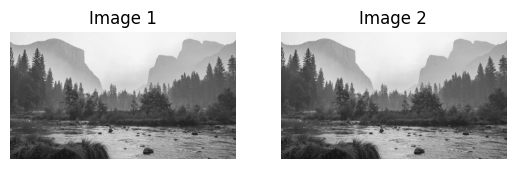

In [7]:
# Load images in grayscale
img1 = cv2.imread("/content/image1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/image1.jpg", cv2.IMREAD_GRAYSCALE)

print("Shapes:", img1.shape, img2.shape)

plt.subplot(1,2,1); plt.imshow(img1, cmap='gray'); plt.title("Image 1"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img2, cmap='gray'); plt.title("Image 2"); plt.axis("off")
plt.show()

In [9]:
import math

def detect_keypoints(img, max_corners=600, quality=0.01, min_dist=8):
    pts = cv2.goodFeaturesToTrack(img, maxCorners=max_corners, qualityLevel=quality, minDistance=min_dist)
    return [] if pts is None else [tuple(pt[0]) for pt in pts]

def compute_sobel(img):
    dx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    return dx, dy

def extract_patch(arr, center, patch_size):
    return cv2.getRectSubPix(arr, (patch_size, patch_size), center)

def surf_like_descriptors(img, keypoints, patch_size=20):
    img_f = img.astype(np.float32)/255.0
    dx, dy = compute_sobel(img_f)
    descs, kp_out = [], []
    half = patch_size // 2

    for (x,y) in keypoints:
        if x-half<0 or y-half<0 or x+half>=img.shape[1] or y+half>=img.shape[0]:
            continue
        dx_p = extract_patch(dx, (x,y), patch_size)
        dy_p = extract_patch(dy, (x,y), patch_size)

        # Orientation (simple dominant gradient)
        ang = math.atan2(dy_p.sum(), dx_p.sum())
        M = cv2.getRotationMatrix2D((patch_size/2, patch_size/2), -np.degrees(ang), 1.0)
        rd_x = cv2.warpAffine(dx_p, M, (patch_size, patch_size))
        rd_y = cv2.warpAffine(dy_p, M, (patch_size, patch_size))

        # Descriptor (4x4 grid × 4 features = 64-D)
        sub = patch_size//4
        desc = []
        for i in range(4):
            for j in range(4):
                rx = rd_x[i*sub:(i+1)*sub, j*sub:(j+1)*sub]
                ry = rd_y[i*sub:(i+1)*sub, j*sub:(j+1)*sub]
                desc.extend([rx.sum(), ry.sum(), np.abs(rx).sum(), np.abs(ry).sum()])
        desc = np.array(desc, dtype=np.float32)
        desc /= (np.linalg.norm(desc)+1e-8)

        kp_out.append(cv2.KeyPoint(float(x), float(y), patch_size))
        descs.append(desc)

    return kp_out, np.array(descs)


From-scratch descriptors: (573, 64) (573, 64)


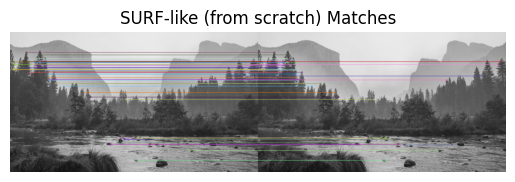

In [10]:
# Detect + compute
kp1, des1 = surf_like_descriptors(img1, detect_keypoints(img1))
kp2, des2 = surf_like_descriptors(img2, detect_keypoints(img2))

print("From-scratch descriptors:", des1.shape, des2.shape)

# Match
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off"); plt.title("SURF-like (from scratch) Matches")
plt.show()